# **filtering mobile phone spam with the naive Bayes algorithm**



#Data cleaning and prepration

In [8]:
sms_raw <- read.csv("spam.csv", stringsAsFactors = FALSE)
str(sms_raw)

'data.frame':	5572 obs. of  2 variables:
 $ type: chr  "ham" "ham" "spam" "ham" ...
 $ text: chr  "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..." "Ok lar... Joking wif u oni..." "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C "U dun say so early hor... U c already then say..." ...


The type variable is currently a character vector. Since this is a categorical variable, it would be better to convert it to a factor, as shown in the following code:

In [9]:
sms_raw$type <- factor(sms_raw$type)
str(sms_raw$type)
table(sms_raw$type)

 Factor w/ 2 levels "ham","spam": 1 1 2 1 1 2 1 1 2 2 ...



 ham spam 
4825  747 

**Data preparation – processing text data for analysis**

1- create a corpus

In [22]:
install.packages("tm")
library(tm)
sms_corpus <- Corpus(VectorSource(sms_raw$text))
inspect(sms_corpus[1:3])

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 3

[1] Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...                                            
[2] Ok lar... Joking wif u oni...                                                                                                                              
[3] Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


Before splitting the text into words, we will need to perform some common cleaning steps in order to remove punctuation and other characters that may clutter the result.

For this, we will use the function tm_map()

In [13]:
# Install necessary packages
if (!require("stringi")) install.packages("stringi")

# Function to handle encoding issues
clean_text <- function(x) {
  # Convert to UTF-8, replacing invalid bytes
  x <- stri_enc_toutf8(x, validate = TRUE)
  # Apply original cleaning steps
  x <- removePunctuation(x)
  x <- removeNumbers(x)
  x <- stripWhitespace(x)
  x <- tolower(x)
  x <- removeWords(x, stopwords())
  return(x)
}

# Apply the cleaning function to the corpus
corpus_clean <- tm_map(sms_corpus, content_transformer(clean_text))

# Inspect the cleaned corpus (first 3 documents)
inspect(corpus_clean[1:3])

Loading required package: stringi

Warning message in stri_enc_toutf8(x, validate = TRUE):
“invalid UTF-8 code point definition; fixing”
Warning message in stri_enc_toutf8(x, validate = TRUE):
“invalid UTF-8 code point definition; fixing”
Warning message in stri_enc_toutf8(x, validate = TRUE):
“invalid UTF-8 code point definition; fixing”
Warning message in stri_enc_toutf8(x, validate = TRUE):
“invalid UTF-8 code point definition; fixing”
Warning message in stri_enc_toutf8(x, validate = TRUE):
“invalid UTF-8 code point definition; fixing”
Warning message in stri_enc_toutf8(x, validate = TRUE):
“invalid UTF-8 code point definition; fixing”
Warning message in stri_enc_toutf8(x, validate = TRUE):
“invalid UTF-8 code point definition; fixing”
Warning message in stri_enc_toutf8(x, validate = TRUE):
“invalid UTF-8 code point definition; fixing”
Warning message in stri_enc_toutf8(x, validate = TRUE):
“invalid UTF-8 code point definition; fixing”
Warning message in stri_enc_toutf8(x, validate 

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 3

[1] go  jurong point crazy available   bugis n great world la e buffet cine  got amore wat                          
[2] ok lar joking wif u oni                                                                                         
[3] free entry   wkly comp  win fa cup final tkts st may text fa   receive entry questionstd txt ratetcs apply overs


The final step is tokenization; we will split the messages into individual components.

In [14]:
sms_dtm <- DocumentTermMatrix(corpus_clean)

# Training and testing the model

We'll begin by splitting the raw data frame into training data and testing data

In [15]:
sms_raw_train <- sms_raw[1:4169, ]
sms_raw_test <- sms_raw[4170:5559, ]

Then we will split the document-term matrix:

In [16]:
sms_dtm_train <- sms_dtm[1:4169, ]
sms_dtm_test <- sms_dtm[4170:5559, ]

And finally, the corpus:

In [17]:
sms_corpus_train <- corpus_clean[1:4169]
sms_corpus_test <- corpus_clean[4170:5559]

To confirm that the subsets are representative of the complete set of SMS data, let's compare the proportion of spam in the training and test data frames:

In [18]:
prop.table(table(sms_raw_train$type))
prop.table(table(sms_raw_test$type))


      ham      spam 
0.8644759 0.1355241 


      ham      spam 
0.8705036 0.1294964 

Both the training data and test data contain about 13 percent spam. This suggests that the spam messages were divided evenly between the two datasets.


**Visualizing text data – word clouds**

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



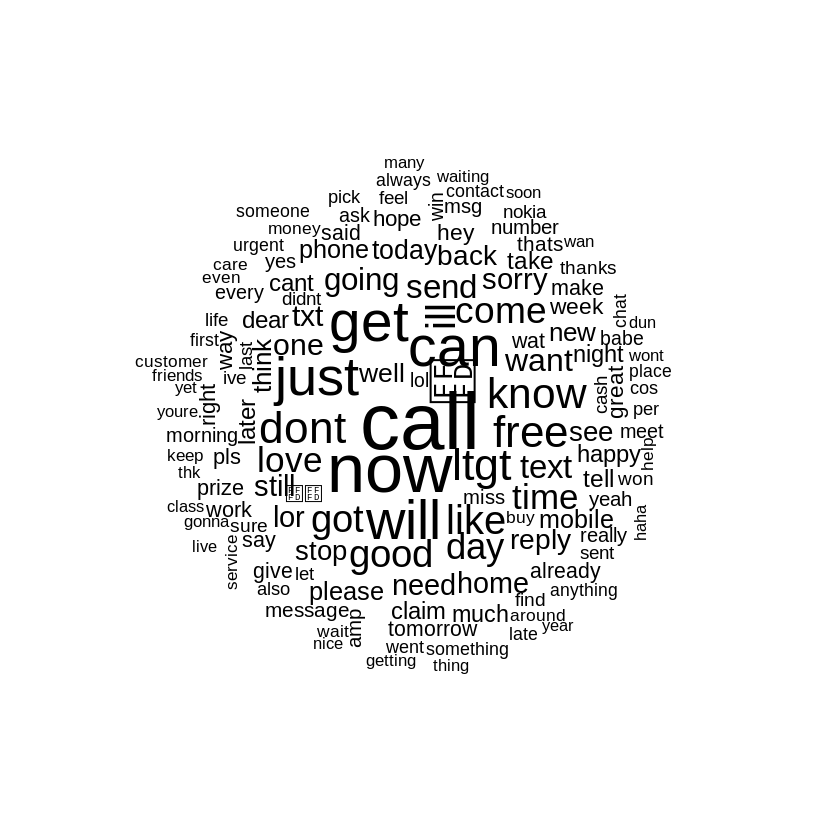

In [19]:
install.packages("wordcloud")
library(wordcloud)
wordcloud(sms_corpus_train, min.freq = 40, random.order = FALSE)

An interesting visualization would be comparing the clouds for SMS spam and ham.


In [26]:
invalid_utf8 <- !stri_enc_isutf8(spam$text)
print(spam$text[invalid_utf8])


  [1] "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, \xe5\xa31.50 to rcv"                                                                            
  [2] "WINNER!! As a valued network customer you have been selected to receivea \xe5\xa3900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only."                                                                  
  [3] "URGENT! You have won a 1 week FREE membership in our \xe5\xa3100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18"                                                                    
  [4] "Thanks for your subscription to Ringtone UK your mobile will be charged \xe5\xa35/month Please confirm by replying YES or NO. If you reply NO you will not be charged"                                                                 
  [5] "As a valued customer, I am pleased to

In [27]:
spam$text <- sapply(spam$text, function(x) stri_replace_all_regex(as.character(x), "[^[:print:]]", ""))
ham$text <- sapply(ham$text, function(x) stri_replace_all_regex(as.character(x), "[^[:print:]]", ""))

In [29]:
spam$text <- tm::removePunctuation(spam$text)
ham$text <- tm::removePunctuation(ham$text)

In [30]:
spam <- subset(spam, nchar(text) > 0)
ham <- subset(ham, nchar(text) > 0)

Warning message in tm_map.SimpleCorpus(corpus, tm::removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, function(x) tm::removeWords(x, tm::stopwords())):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, tm::removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, function(x) tm::removeWords(x, tm::stopwords())):
“transformation drops documents”


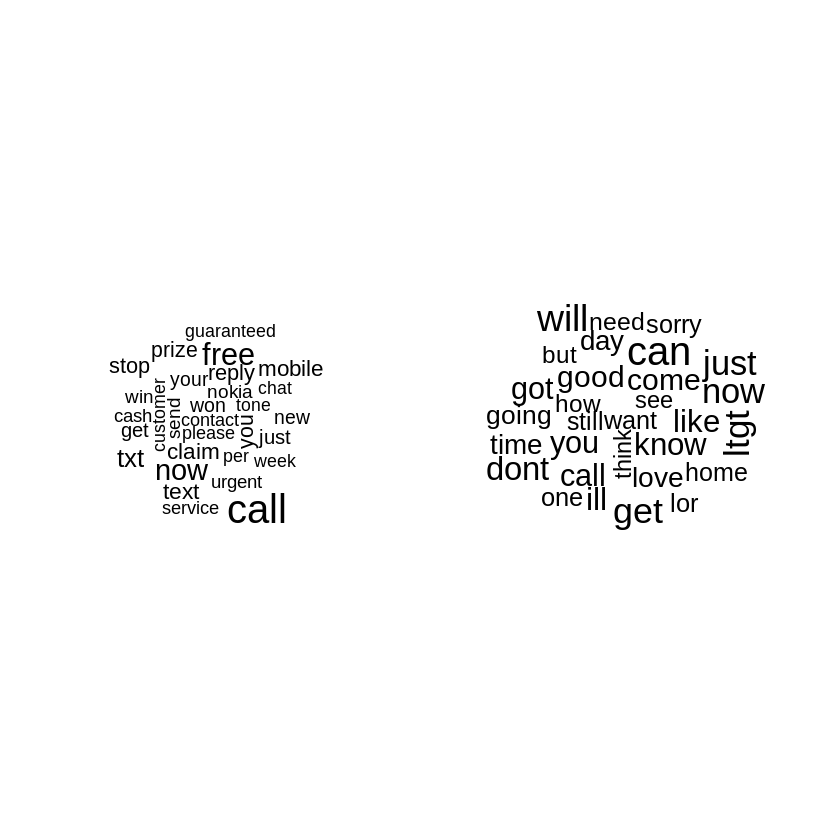

In [47]:
# Set up the plotting area to have 1 row and 2 columns
par(mfrow = c(1, 2), mar = c(1, 1, 1, 1))
# Create the word cloud for the spam text
wordcloud(spam$text, max.words = 30, scale = c(2, 0.7))

# Create the word cloud for the ham text
wordcloud(ham$text, max.words = 30, scale = c(2, 0.7))

# Reset the plotting layout to default (1 plot per page)
par(mfrow = c(1, 1))

**Creating indicator features for frequent word**

To reduce the number of features, we will eliminate any words that appear in less than about 0.1 percent of records in the training data.


In [56]:
frequent_terms <- findFreqTerms(sms_dtm_train, 5)

We will now create 2 variables;
 sms_train_filtered and sms_test_filtered,  which are  document-term matrices containing only the frequent terms from the training and testing datasets, respectively.

In [57]:
sms_train_filtered <- sms_dtm_train[, frequent_terms]
sms_test_filtered <- sms_dtm_test[, frequent_terms]

The training and test datasets are composed of the new features that we will use to train our model.

One issue we have for now is that the Naive Bayes classifier works with **categorical data**; however, our DTM is all numerical, and each cell contains how many times a token (word) appears in a text document (sms).

To overcome this, we will use the convert_counts() function, which will convert the word counts into categorical data: Yes/No.


In [63]:
convert_counts <- function(x) {
 x <- ifelse(x > 0, 1, 0)
 x <- factor(x, levels = c(0, 1), labels = c("No", "Yes"))
return(x)
}
sms_train_filtered <- apply(sms_train_filtered, MARGIN = 2, convert_counts)
sms_test_filtered <- apply(sms_test_filtered, MARGIN = 2, convert_counts)

**Training the model**
We will ude the naiveBayes() fucntion in the e1071 package for this.

In [64]:
install.packages("e1071")
library(e1071)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘proxy’




To build our model on the sms_train_filetered matrix, we'll use the following command:

In [65]:
sms_classifier <- naiveBayes(sms_train_filtered, sms_raw_train$type)

# **Evaluating Model Performance**

In [66]:
sms_test_pred <- predict(sms_classifier, sms_test_filtered)

To compare the predicted values to the actual values, we'll use the CrossTable() function in the gmodels package:
library(gmodels)

In [71]:
install.packages("gmodels")
library(gmodels)
CrossTable(sms_test_pred, sms_raw_test$type, prop.chisq = FALSE, prop.t = FALSE, dnn = c('predicted', 'actual'))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gtools’, ‘gdata’





 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1390 

 
             | actual 
   predicted |       ham |      spam | Row Total | 
-------------|-----------|-----------|-----------|
         ham |      1205 |        26 |      1231 | 
             |     0.979 |     0.021 |     0.886 | 
             |     0.996 |     0.144 |           | 
-------------|-----------|-----------|-----------|
        spam |         5 |       154 |       159 | 
             |     0.031 |     0.969 |     0.114 | 
             |     0.004 |     0.856 |           | 
-------------|-----------|-----------|-----------|
Column Total |      1210 |       180 |      1390 | 
             |     0.871 |     0.129 |           | 
-------------|-----------|-----------|-----------|

 


Looking at the table, we can see that 5 of 1210 ham messages (**0.41 percent**) were incorrectly classified as spam, while 26 of 180 spam messages (14.44 percent) were incorrectly classified as ham. Considering the little effort we did, this level of performance seems quite impressive. This case study exemplifies the reason why **naive Bayes is the standard for text classification**; directly out of the box, it performs surprisingly well


#**Improving Model Performance**

When tarining our model, we didn't set the laplace parameter when running the naive Bayes(), thus we will inlcude it right now.

In [80]:
sms_classifier2 <- naiveBayes(sms_train_filtered, sms_raw_train$type, laplace = 0.1)
sms_test_pred2 <- predict(sms_classifier2, sms_test_filtered)

 Finally, we'll compare the predicted classes to the actual classifications using a cross tabulation again:

In [81]:
 CrossTable(sms_test_pred2, sms_raw_test$type,
    prop.chisq = FALSE, prop.t = FALSE, prop.r = FALSE,
    dnn = c('predicted', 'actual'))


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1390 

 
             | actual 
   predicted |       ham |      spam | Row Total | 
-------------|-----------|-----------|-----------|
         ham |      1208 |        20 |      1228 | 
             |     0.998 |     0.111 |           | 
-------------|-----------|-----------|-----------|
        spam |         2 |       160 |       162 | 
             |     0.002 |     0.889 |           | 
-------------|-----------|-----------|-----------|
Column Total |      1210 |       180 |      1390 | 
             |     0.871 |     0.129 |           | 
-------------|-----------|-----------|-----------|

 


After tuning the **Laplace parameter**, the number of false positives (ham messages erroneously classified as spam) from 5 to 2, we also reduced the number of false negatives
from 26 to 20.

We can now say that our model is complete!